# STILL NONSENSE TESTING - IGNORE 

In [137]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
from braincoder.utils.visualize import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


# Simulate data

In [2]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
# sfs_seq = np.append(sfs_seq, np.zeros(500))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
# con_seq = np.append(con_seq, np.zeros(500))
paradigm = np.vstack([sfs_seq, con_seq])


In [3]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [109]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.68, 0.68],     # we fix width_l in our model
    'crf_exp'   : [0, 5] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
n_vx = 100
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [111]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

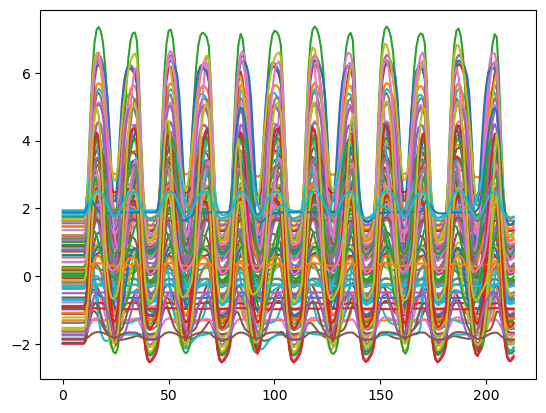

In [112]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

# Classic fitter

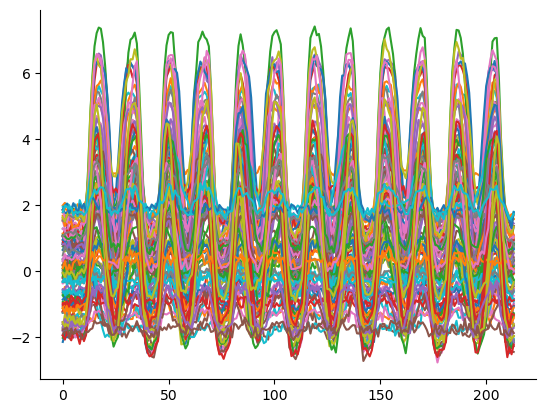

In [113]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [114]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r     =np.linspace(bounds['width_r'][0], bounds['width_r'][1], 5),
    SFp         =np.linspace(bounds['SFp'][0], bounds['SFp'][1], 5),
    CSp         =np.linspace(bounds['CSp'][0], bounds['CSp'][1], 10),
    width_l     =np.linspace(bounds['width_l'][0], bounds['width_l'][1], 5),
    crf_exp     =np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], 5),
    amplitude   =[1.0],
    baseline    =[0],
    use_correlation_cost=True
)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, fixed_pars={'width_l' : 0.68})

Working with chunk size of 31152
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:426: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.10825348e+00 1.00000000e-04 1.48349142e+00 2.40478039e+00
 4.01714802e+00 4.79512262e+00 7.50466204e+00 5.12052870e+00
 2.70724273e+00 4.07017374e+00 3.32315826e+00 2.02744174e+00
 5.30471230e+00 1.52764738e+00 8.91307545e+00 1.80569375e+00
 4.37020063e+00 4.39190626e+00 4.13819122e+00 6.78907824e+00
 3.79945970e+00 6.28409564e-01 1.00000000e-04 1.14003360e+00
 6.98440552e+00 5.55104828e+00 1.86036491e+00 4.64835548e+00
 1.01523066e+00 2.54098725e+00 5.94707847e-01 3.36704135e+00
 8.83757877e+00 2.83473462e-01 6.66480732e+00 1.07740057e+00
 7.18477821e+00 8.54071236e+00 2.90661407e+00 5.74825430e+00
 2.58507043e-01 5.92994499e+00 3.06573319e+00 8.65287876e+00
 8.11176538e-01 3.66675186e+00 6.24918699e-01 2.97387671e+00
 8.62532616e+00 9.

*** Only fitting: ***
 * width_r
 * SFp
 * CSp
 * crf_exp
 * amplitude
 * baseline
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: nan/Best R2: 0.87068: 100%|██████████| 1000/1000 [00:07<00:00, 138.24it/s]


/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_55593/3362790475.py:21: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(bounds[param])
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_55593/3362790475.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(bounds[param])


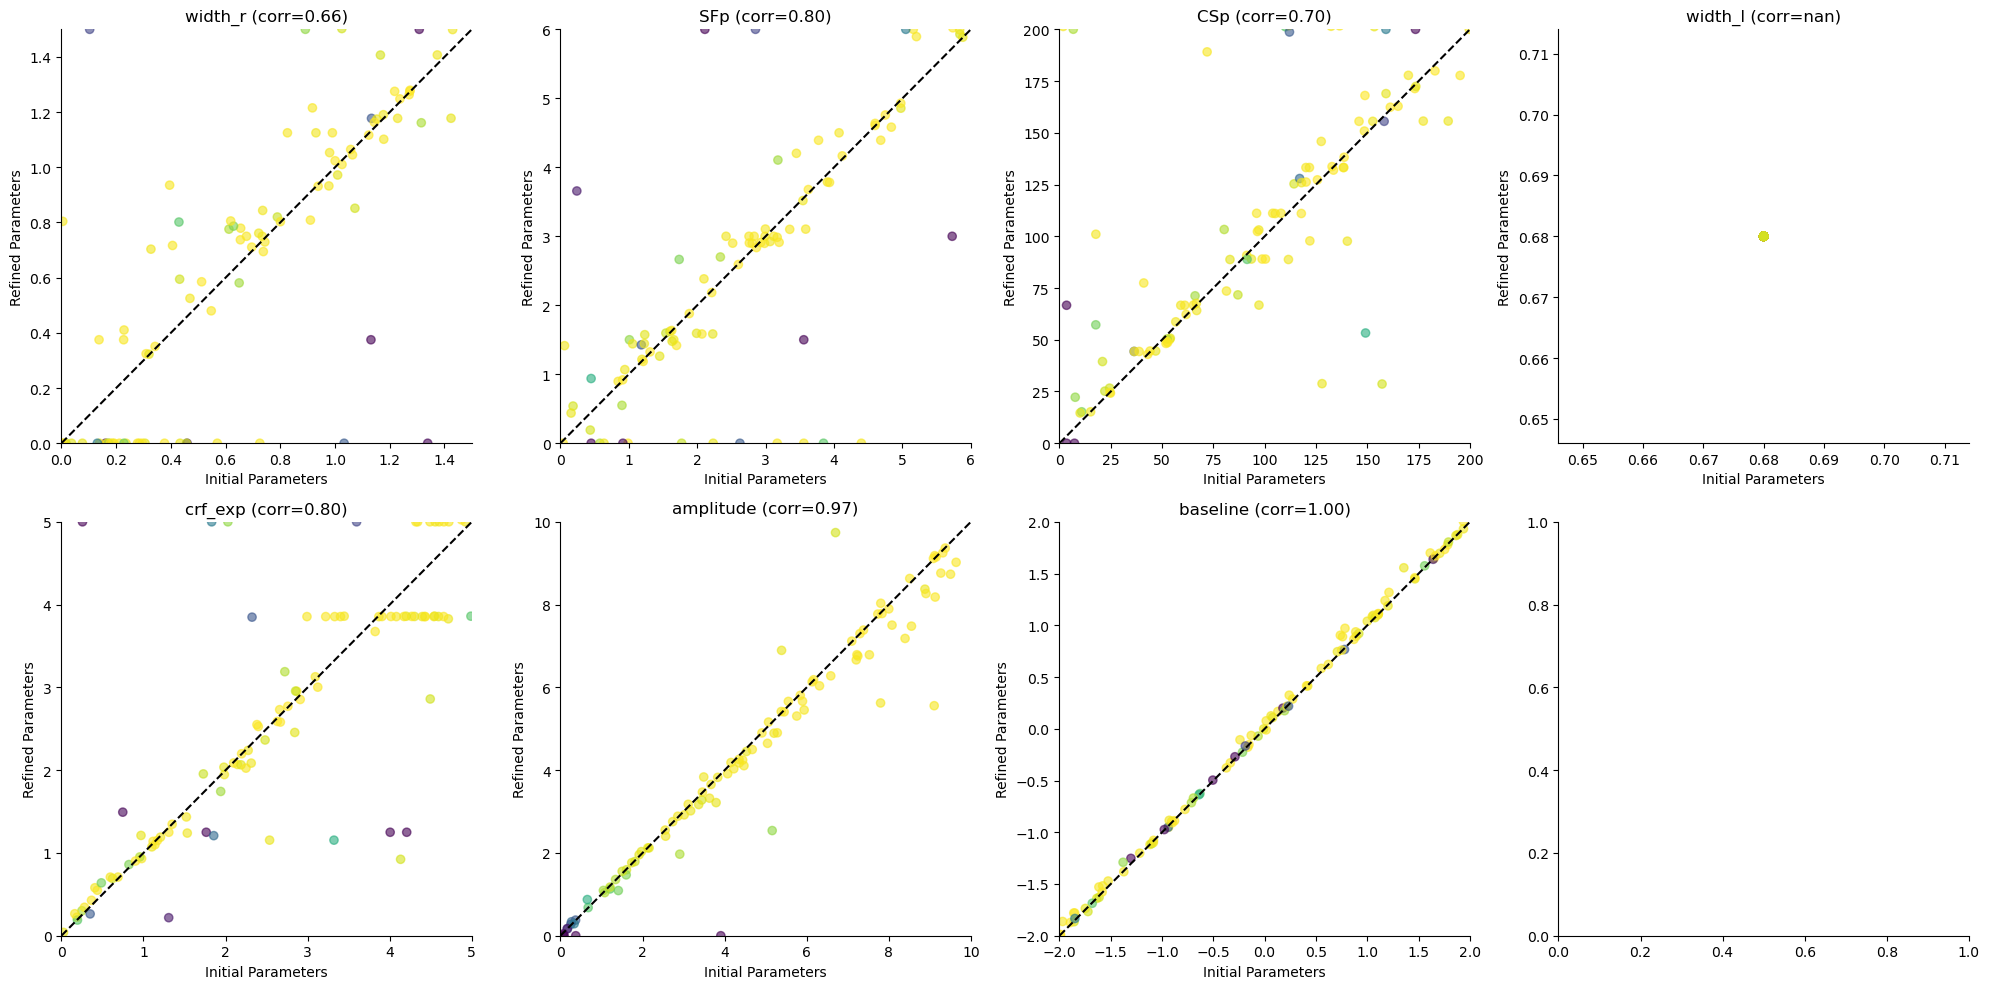

In [115]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
rsq = cfitter.get_rsq(parameters=refined_pars)
for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        c=rsq, 
        alpha=0.6,
        cmap='viridis',
        vmin=0, vmax=1,
        )
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')
    sns.despine()

plt.tight_layout()
plt.show()

In [136]:
bfitter = BPRF(model, data, noise_method='fit_tdist')
# bfitter.add_priors_from_bounds(
#     bounds, 
# )
bfitter.add_bijector_from_bounds(
    bounds
)


init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 2,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
    'noise_dof' : np.ones(n_vx) * 1, 
    'noise_scale' : np.ones(n_vx) * .5, 
}
init_pars = pd.DataFrame(init_pars)

bfitter.fit_mcmc(
    idx=[0,1,2,3,4],
    init_pars=init_pars,
    fixed_pars={'width_l':0.68},
    num_steps=10,
    burnin=50, 
    # max_tree_depth=5, 
    # target_accept_prob=0.85, 
)
print(bfitter.mcmc_stats['elapsed_time'])

Lets run some checks with everything...
tf.Tensor([-412.90616 -576.1608  -468.72302 -594.93097 -323.57452], shape=(5,), dtype=float32)
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [ -8.40497   18.185493 -20.59512  -14.416557 -24.600447]
Gradient for parameter 1: [ 2.585227  -4.3357816  4.719497   3.3743372  6.9022856]
Gradient for parameter 2: [-0.01178602 -0.13174586  0.16637291  0.11661074  0.10669587]
Gradient for parameter 3: [0. 0. 0. 0. 0.]
Gradient for parameter 4: [ 6.308712  -2.5243988  2.5613556  1.1344376 12.36113  ]
Gradient for parameter 5: [ -3.5421524 -52.594757   63.26368    44.42632    60.787796 ]
Gradient for parameter 6: [-114.89181 -266.18918  326.7824   259.68143   45.1477 ]
Gradient for parameter 7: [  5.4237204  -9.138047   28.89087   -18.637085   44.57083  ]
Gradient for parameter 8: [ 60.84784  329.1101   266.35016  328.65417   38.772797]
initial_ll=[-412.90616 -576.1608  -468.72302 -594.93097 -323.57452]
Starting

In [38]:
# import pickle
# with open('./bfitter_big_sim.pkl', 'wb') as file:
#     pickle.dump(bfitter.mcmc_sampler, file)

In [ ]:
bfitter.mcmc_stats.keys()
# bfitter.mcmc_stats['leapfrogs_taken']



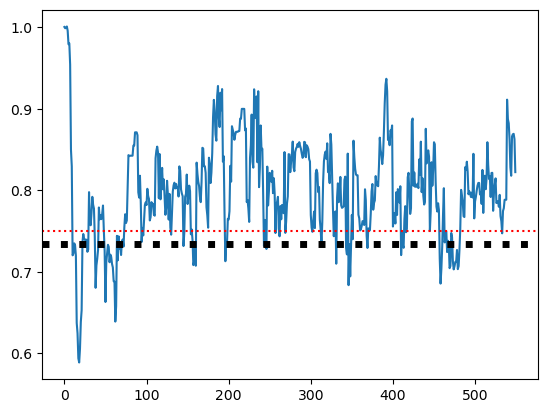

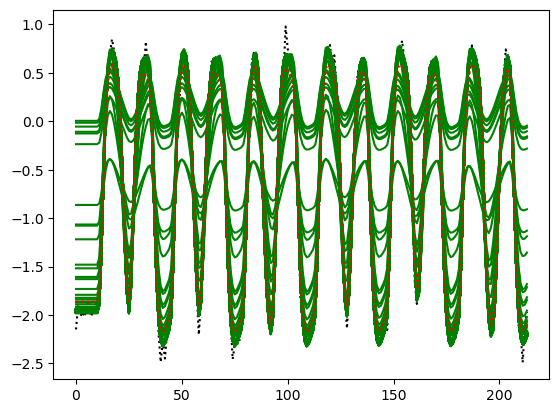

In [132]:
idx = 0
p = 'width_r'
plt.plot(
    bfitter.mcmc_sampler[idx][p]
)
try:
    plt.axhline(parameters[p][idx], linestyle=':', color='k', lw=5)
    plt.axhline(refined_pars[p][idx] , linestyle=':', color='r')
except:
    print('nope')
plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

In [64]:
bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])

0     -1.376713
1     -1.376713
2     -1.376713
3     -0.010989
4      0.352309
         ...   
545    0.987790
546    0.987570
547    0.987356
548    0.987669
549    0.987757
Name: r2, Length: 550, dtype: float32

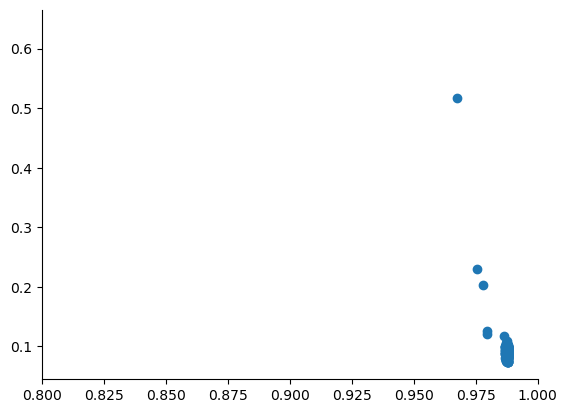

In [70]:
rsq = bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])
from dag_prf_utils.plot_functions import *
dag_scatter(
    X=rsq, Y=bfitter.mcmc_sampler[0]['noise_scale'].values, #pc=bfitter.mcmc_sampler[0]
    x_lim=[.8,1]
)


In [51]:
rsq.argmax()

0

In [ ]:
bfitter.mcmc_sampler[0]

RangeIndex(start=0, stop=550, step=1)

In [ ]:
data

In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
bfitter.mcmc_sampler[idx][p]

In [ ]:
idx = 1
rsq = bfitter.get_rsq_for_idx(
    idx=idx, 
    parameters=bfitter.mcmc_sampler[idx]

)
plt.plot(rsq)

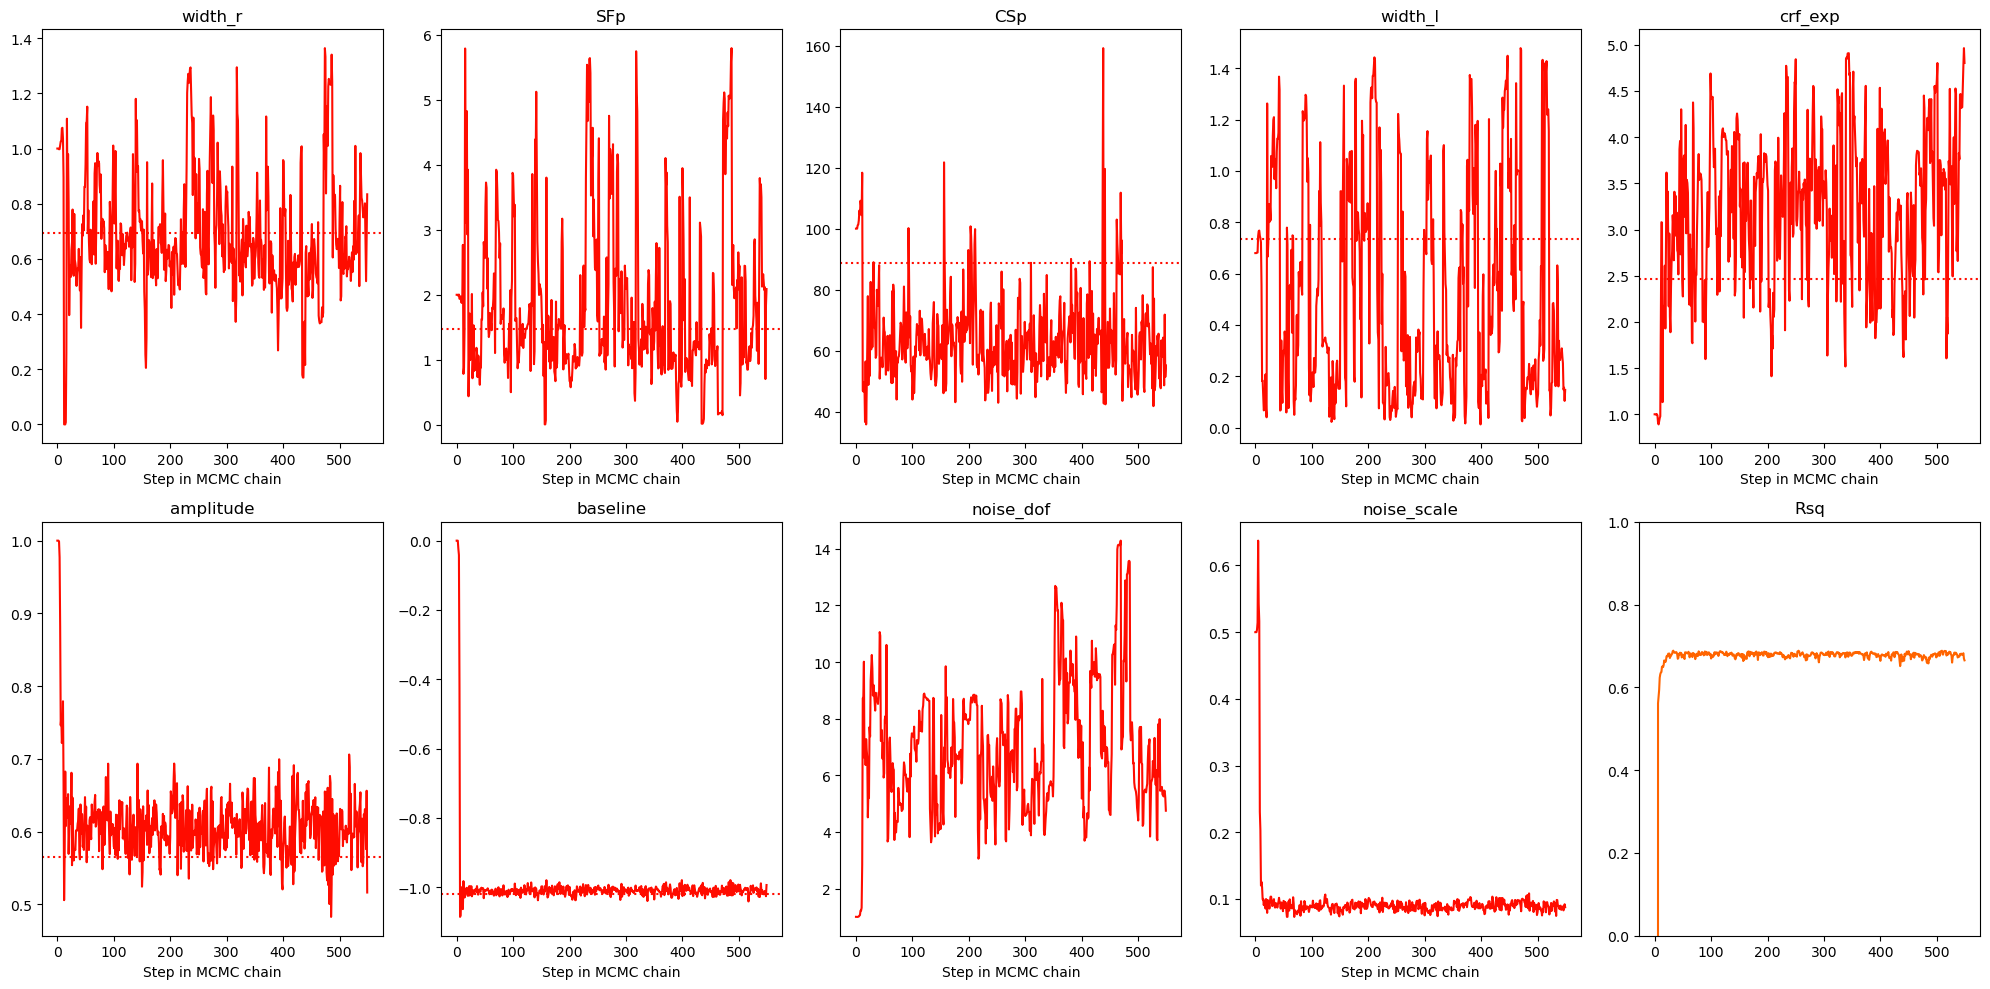

In [77]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,5,figsize=(20,10))
axs = axs.flatten()
idx = 0
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    # for i in range(10):

    ax.plot(
        bfitter.mcmc_sampler[idx][p],# - parameters[p][idx],
        color=idx_cols[idx],        
        )
    try:
        # Lets add the ground truth
        ax.axhline(
            parameters[p][idx], 
            color=idx_cols[idx],        
            linestyle=':'
        )
    except:
        continue
ax = axs[-1]
ax.set_title('Rsq')

rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)
plt.plot(
    rsq, 
    color=idx_cols[i]
    ) 
plt.ylim(0,1)
plt.tight_layout()

/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_55593/3710284185.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


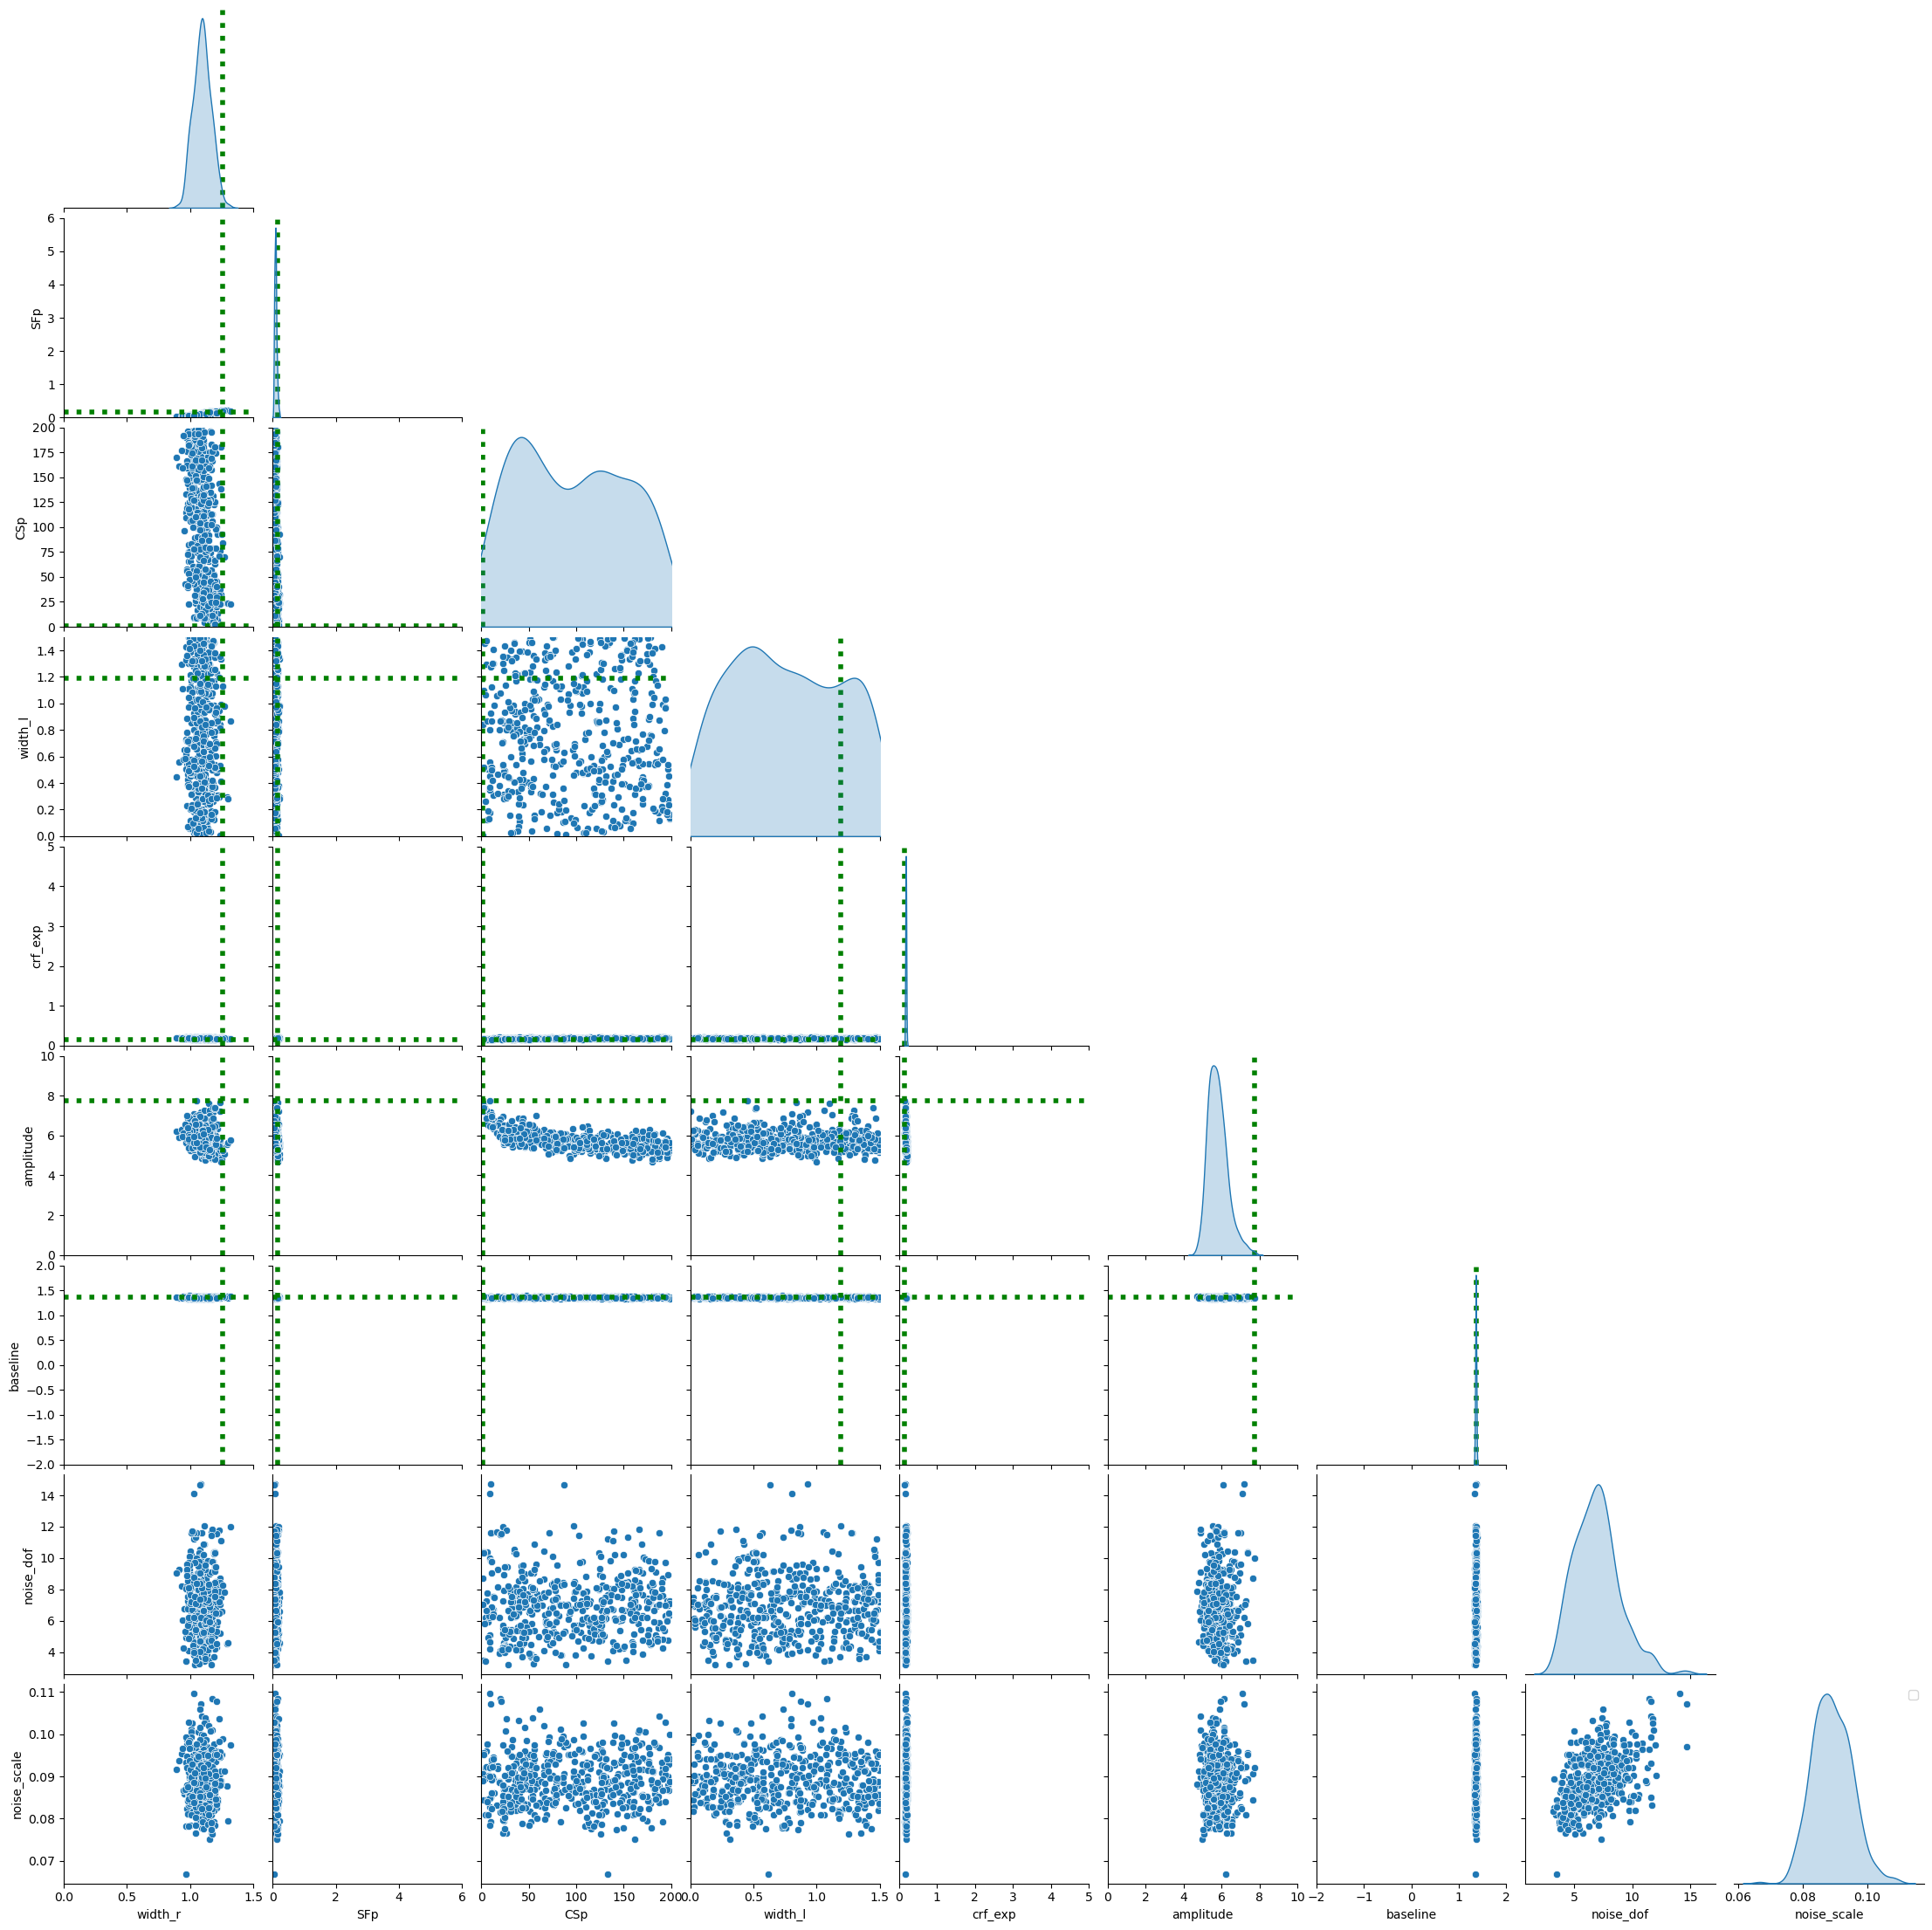

In [92]:
idx = 20
burn_in = 50
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    # plot_kws={'color':rsq_cols[burn_in:,:]},
    corner=True, 
    diag_kind='kde'
)
# sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
step_sizes = [.00001,  0.001, 0.005, 0.01, 0.05]
unrolled_steps = [1, 2, 3]
tree_depths = [5, 10, 15]

for step_size in step_sizes:
    for unroll in unrolled_steps:
        for depth in tree_depths:
            print(f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}")
            try:
                bfitter.fit_all(
                    init_pars=init_pars,
                    num_steps=10,
                    burnin=10, 
                    unrolled_leapfrog_steps=unroll,
                    step_size=step_size,
                    max_tree_depth=depth
                )
            except Exception as e:
                print(f"Failed with error: {e}")
            plt.figure()
            rsq = []
            for idx in range(bfitter.n_voxels):
                rsq.append(bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx]).T)
            plt.plot(np.array(rsq).T)
            plt.title(
                f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}"
            )
        bloop





In [ ]:
idx = 10


In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
idx = 1
burn_in = 100
plt.plot(cfitter.data.iloc[:,idx], ':k')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
plt.text(
    x=1, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"TRUTH {idx}:\n{parameters.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
plt.text(
    x=1.3, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"FIT {idx}:\n{refined_pars.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

In [ ]:
idx = 500
pred = bfitter.get_predictions(
    parameters=bfitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
# colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,burn_in:],
    # c=colors,
)
plt.plot(data.iloc[:,idx])


In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

width_r       0.588419
SFp           4.213627
CSp          85.103714
width_l       0.986515
crf_exp       4.665264
amplitude     0.030873
baseline     -0.635326
Name: 1, dtype: float32


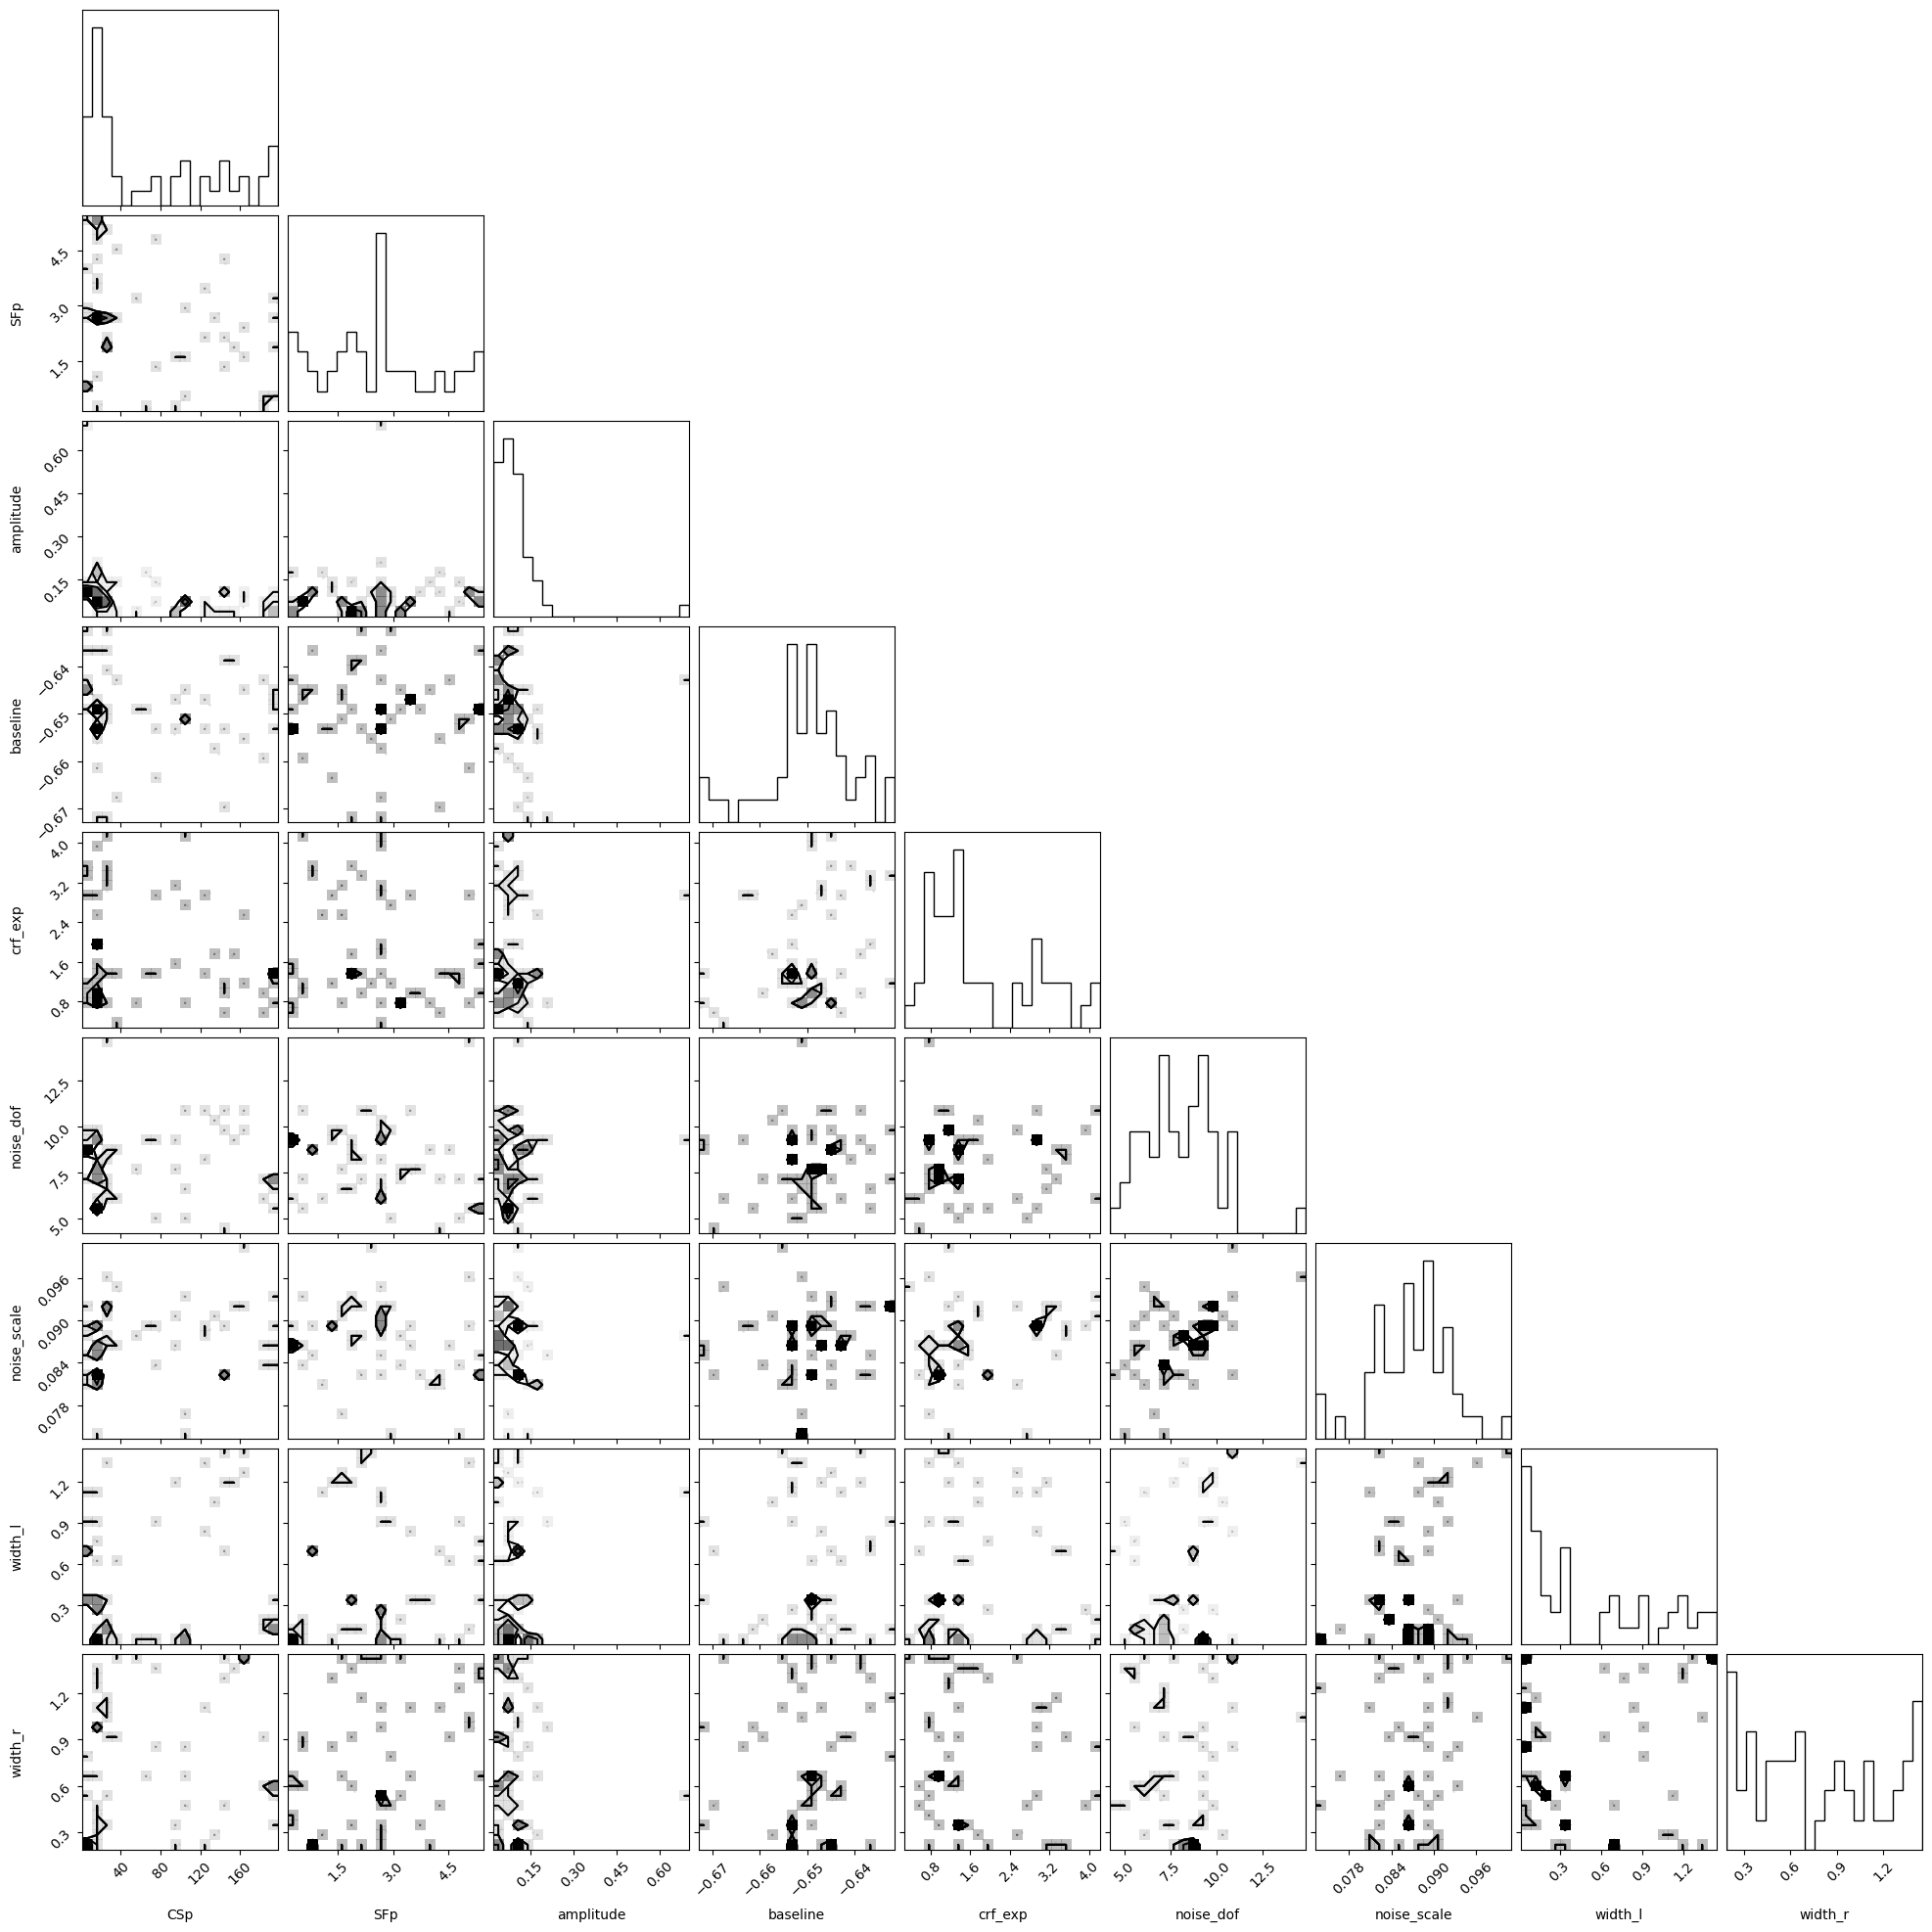

In [75]:
import corner as corner
_ = corner.corner(
    bfitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
